# API development for download of Sentinel-2 and Landsat-8 data
### User defined mosaicing of harmonised products
_Robin Kohrs & Konstantin Schellenberg, February 2020, GEO 419_  
_Supervisor: John Truckenbrodt¹, Martin Habermeyer²_ <br>
<sub><sub>
¹ Friedrich-Schiller-University Jena, chair of remote sensing <br>
² Deutsches Luft- und Raumfahrtszentrum, earth observation center
</sub></sub>

## Tutorial
This is the extention for nasa_hls. We developed following new functions:

In order to make the program be more flexible, the goal of this extension is to
1. Download tiles by setting spatial (user defined verctor geometry) and temporal inqueries to the HLS server,
2. Mosaic the HDF4 formatted product per band and acquisition date.

As part of the module report will want to add the following post procession tasks: 
3. Calculate spectral indexes from the downloaded products.
4. Plot the results inline with `ipyleafet` and `folium` on a Open Street Map WMS service.

Tasks 1 and 2 are meant to work in accordance with the `nasa_hls` package and aims to lead to a pull request to the repository; 3 and 4 shall give an overview of to use the new utilities and the HLS product.

User guide to the HLS product:
https://hls.gsfc.nasa.gov/wp-content/uploads/2019/01/HLS.v1.4.UserGuide_draft_ver3.1.pdf

## <font color = "red"> Download HSL files with user input</font>

In [1]:
# change working directory 
import os
os.chdir("/home/robin/python_projects/nasa_hls")

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
%matplotlib inline

import nasa_hls
import sys
import pandas as pd
import os
from osgeo import gdal
import geopandas as gpd
from fiona.crs import from_epsg
gdal.UseExceptions()

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# and for later processing in the notebook

- For testing purpose, try downloading the kml file:

In [4]:
nasa_hls.download_kml()

UTM tiles already successfully downloaded to:
 /home/robin/.nasa_hls/.auxdata/utm.kml 



'/home/robin/.nasa_hls/.auxdata/utm.kml'

## <font color = "red">Make list with GeoDataFrames</font>

- This will serve as a conformation for the user
- It's a list of lists. Each inner list beeing the GeoDataFrames for the specified dates

In [6]:
# define user shape
shape_path="/home/robin/python_projects/data/nasa_hls/test_shape/dummy_region.shp"

In [6]:
ds = nasa_hls.make_tiles_dataset(shape=shape_path,
                                products=["S30"],
                                start_date="2018-12-25")


starting date: 2018-12-25
 
UTM tiles already successfully downloaded to:
 /home/robin/.nasa_hls/.auxdata/utm.kml 



  0%|          | 0/4 [00:00<?, ?it/s]


getting available datasets . . .


100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


In [7]:
# print the list of lists
print(ds, "\n\n")
print("The query starting at date '2018-12-25', resulted in {len} hls-prodcuts".format(len = len(ds)))


[    product   tile       date                                                url
65      S30  34JDN 2018-12-27  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...
200     S30  34JEN 2018-12-27  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...
268     S30  34JDP 2018-12-27  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...
403     S30  34JEP 2018-12-27  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...,     product   tile       date                                                url
201     S30  34JEN 2018-12-29  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...
404     S30  34JEP 2018-12-29  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...] 


The query starting at date '2018-12-25', resulted in 2 hls-prodcuts


- As one can see in the list, there are 4 scenes for the 27th of december and two products for the 29th.

***
## <font color = "red">Download Tiles</font>

- Taking the list from above, the data sources can be downloaded via the function `download_tiles`. 

- This function calls `download_batch` and other methods internally in order to parse the right URLs for download.

- The path for the parameter `dir` needs to be adapted, as this is user-specific.

In [8]:
# where the user wants the ".hdf"-files
hdf_path = "/home/robin/python_projects/data/nasa_hls/hdf_tiles"

In [7]:
nasa_hls.download_tiles(dstdir=hdf_path,
                        dataframes=ds)

100%|██████████| 2/2 [00:53<00:00, 26.65s/it]


In [9]:
# the size of one ".hdf"-file
s = os.path.getsize(os.path.join(hdf_path , "HLS.S30.T34JDN.2018361.v1.4.hdf"))
print("The first downloaded 'hdf'-file is {0:.2f} MB in size on the disk".format(s/1e6))

The first downloaded 'hdf'-file is 244.24 MB in size on the disk


***
## <font color = "red">Mosaicing tiles</font>
- Now we'll create a mosaic for each day. Internally there are two steps. First creating a mosaic for each band for each day. And afterwards creating a mosaic for each day of all the single bands.
- This is done by the function `make_mosaic`.

In [7]:
# for simplicity make input and output file directories the same
# tiffs will end up in the same directory
# note the "/" at the end
final_dir = "/home/robin/python_projects/data/nasa_hls/hdf_tiles/"

In [8]:
# %%capture
#bands is set to None in order to use all bands
# as we downloaded Sentinel-Scenes, the argument `products` is given the paramter "S30"
nasa_hls.make_mosaic(srcdir=final_dir, dstdir=final_dir, product="S30", shape = shape_path)

i'm in, sentinel!!
The selected band names are: 

long band names:  ['B01', 'B02', 'B03', 'B04', 'B05', 'B07', 'B08', 'B8A', 'B10', 'B11', 'B12', 'QA']
The selected band names are: 

long band names:  ['B01', 'B02', 'B03', 'B04', 'B05', 'B07', 'B08', 'B8A', 'B10', 'B11', 'B12', 'QA']

the unique days are: 
 ['361', '363'] 

['/home/robin/.nasa_hls/.auxdata/mosaic/bands/363B12.vrt', '/home/robin/.nasa_hls/.auxdata/mosaic/bands/361B05.vrt', '/home/robin/.nasa_hls/.auxdata/mosaic/bands/363B04.vrt', '/home/robin/.nasa_hls/.auxdata/mosaic/bands/361B12.vrt', '/home/robin/.nasa_hls/.auxdata/mosaic/bands/361B03.vrt', '/home/robin/.nasa_hls/.auxdata/mosaic/bands/361B8A.vrt', '/home/robin/.nasa_hls/.auxdata/mosaic/bands/361QA.vrt', '/home/robin/.nasa_hls/.auxdata/mosaic/bands/363B10.vrt', '/home/robin/.nasa_hls/.auxdata/mosaic/bands/361B01.vrt', '/home/robin/.nasa_hls/.auxdata/mosaic/bands/361B02.vrt', '/home/robin/.nasa_hls/.auxdata/mosaic/bands/361B10.vrt', '/home/robin/.nasa_hls/.auxdata/mosa

***
## <font color = "red">Print Results</font>

In [9]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib as mpl
import fiona
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from descartes import PolygonPatch

In [10]:
#filepath of one of the rasters (hdf-scenes)
fp = "/home/robin/python_projects/data/nasa_hls/hdf_tiles/361.tiff"

In [12]:
#print dimensions of raster
rio_raster = rio.open(fp) #produces rasterio.DatasetReader
print(type(rio_raster) )
print(rio_raster.bounds)

<class 'rasterio.io.DatasetReader'>
BoundingBox(left=399960.0, bottom=-3309780.0, right=609780.0, top=-3099960.0)


In [13]:
# load it into a numpy array
with rio.open(fp) as src:
    data = src.read() # produces numpy nd array
type(data)

numpy.ndarray

In [65]:
# Confirm that there are 12 bands for Sentinel Scenes
data.shape

(12, 6994, 6994)

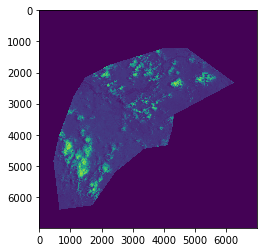

In [14]:
# show first band cropped to our shapefile
show((data[0,:,:]))

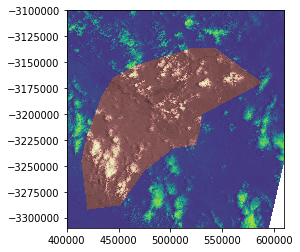

In [15]:
# get the entire (uncropped) raster 
fp_vrt = "/home/robin/.nasa_hls/.auxdata/mosaic/days/361final.vrt"
raster_vrt = rio.open(fp_vrt)

#and plot both together
fig, ax = plt.subplots()
show(raster_vrt, ax = ax)
show(rio_raster, cmap = "pink", ax = ax)


In [17]:
# now add the shape
shape = gpd.read_file(shape_path)
print(shape.crs)
shape = shape.to_crs("EPSG:32634")
print(shape.crs)

{'init': 'epsg:4326'}
EPSG:32634


Text(0.5, 1, 'User-shape, full hls-scene and cropped scene')

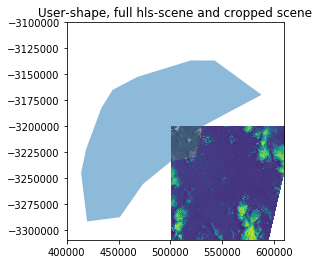

In [69]:
#and plot both together
fig, ax = plt.subplots()
shape.plot(ax = ax, alpha=.5)
show(raster_vrt, ax = ax)
show(rio_raster, cmap = "pink", ax = ax)
ax.set_title("User-shape, full hls-scene and cropped scene")


### get some metadata

In [28]:
# get the dimension of the cropped raster by reading the first band
first_band_array = rio_raster.read(1)
first_band_array_uncropped = raster_vrt.read(1)
print("the cropped rasters dimension is \n", first_band_array.shape)
print("")
print("the uncropped rasters dimension is \n", first_band_array_uncropped.shape)

the cropped rasters dimension is 
 (6994, 3660)

the uncropped rasters dimension is 
 (6994, 3660)


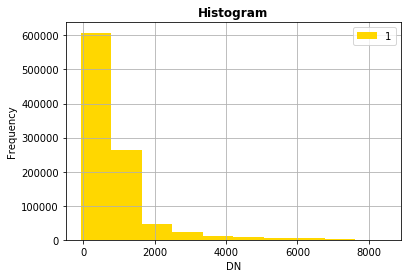

In [42]:
show_hist((rio_raster, 1), lw = 0.0)

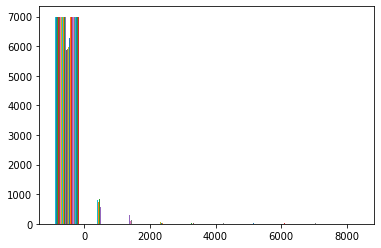

In [33]:
# when plotted as numpy array_first_band you can see the nodata-values of -1000
plt.hist(first_band_array, bins = 10)
plt.show()

In [29]:
#how many values with -1000
sum_neg = (first_band_array == -1000).sum()
sum_neg 

25319233

In [30]:
# what are  datatype and the nodata-values in the final tiff
for i, dtype, nodataval in zip(rio_raster.indexes, rio_raster.dtypes, rio_raster.nodatavals):
    print(i, dtype, nodataval)

1 int16 -1000.0
2 int16 -1000.0
3 int16 -1000.0
4 int16 -1000.0
5 int16 -1000.0
6 int16 -1000.0
7 int16 -1000.0
8 int16 -1000.0
9 int16 -1000.0
10 int16 -1000.0
11 int16 -1000.0
12 int16 -1000.0


In [31]:
# what are  datatype and the nodata-values in the vrt, that makes the final tiff above?
for i, dtype, nodataval in zip(raster_vrt.indexes, raster_vrt.dtypes, raster_vrt.nodatavals):
    print(i, dtype, nodataval)

1 int16 -1000.0
2 int16 -1000.0
3 int16 -1000.0
4 int16 -1000.0
5 int16 -1000.0
6 int16 -1000.0
7 int16 -1000.0
8 int16 -1000.0
9 int16 -1000.0
10 int16 -1000.0
11 int16 -1000.0
12 uint8 255.0


- As one can see there is one band that is just of datatype `uint8` instad of being `int16`. This is the QA-Band with a nodata-value of 255


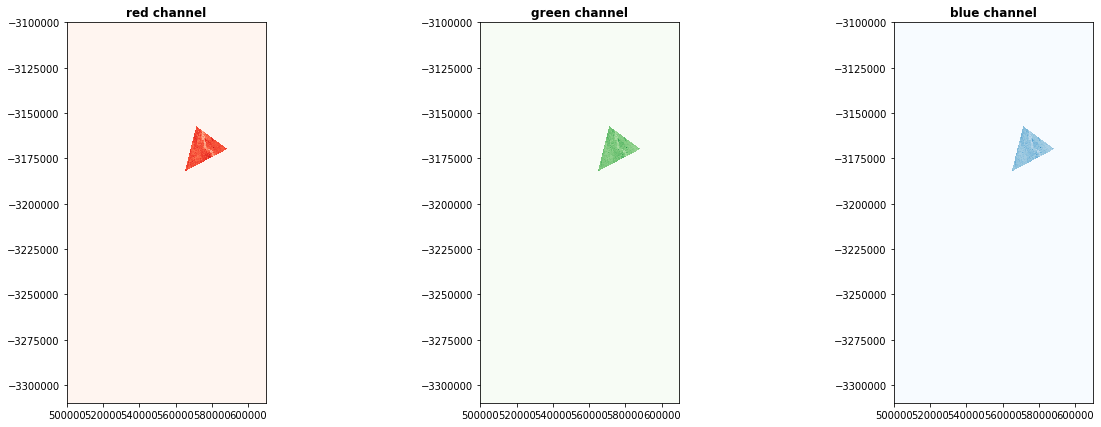

In [32]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((rio_raster,4), ax = axr, cmap = "Reds", title = "red channel")
show((rio_raster,3), ax = axg, cmap = "Greens", title = "green channel")
show((rio_raster,2), ax = axb, cmap = "Blues", title = "blue channel" )


In [33]:
red = rio_raster.read(4)
green = rio_raster.read(3)
blue = rio_raster.read(2)

In [46]:
# convert -1000 to NAN
first_band_array = first_band_array.astype("float")
first_band_array[first_band_array == -1000] = np.NAN

In [43]:
# convert values to float
red_array = red.astype("float")
green_array = green.astype("float")
blue_array = blue.astype("float")

In [55]:
red_array[red_array == -1000] = np.NAN
green_array[green_array == -1000] = np.NAN
blue_array[blue_array == -1000] = np.NAN

In [73]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)


print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())


Normalized bands
0.0 - 1.0 mean: 0.00665637826450945
0.0 - 1.0 mean: 0.004974916654508521
0.0 - 1.0 mean: 0.004231888973689798


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


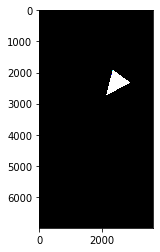

In [57]:
# stack bands together
rgb = np.dstack((red_array, green_array, blue_array))
plt.imshow(rgb)

In [9]:
import folium
from folium import plugins


In [163]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [6]:
# Create variables for destination coordinate system and the name of the projected raster
dst_crs = 'EPSG:4326' 
out_path = os.path.join("/home/robin/python_projects/data/nasa_hls/hdf_tiles/361reproj.tiff")

In [165]:
with rio.open(fp) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rio.open(out_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
            source=rio.band(src, i),
            destination=rio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)
            

In [7]:
# Use rasterio to import the reprojected data as img
with rio.open(out_path) as src:
    boundary = src.bounds
    img = src.read()
    nodata = src.nodata

In [178]:
boundary


BoundingBox(left=19.963667971927634, bottom=-29.918757934481075, right=22.137246175294752, top=-28.020356587436716)

In [10]:
map_= folium.Map(location=[20, -29],
                  tiles='Stamen Terrain', zoom_start = 8)

In [16]:
img = folium.raster_layers.ImageOverlay(
        name='Mercator projection SW',
        image=img[0],
        bounds=[[19.96, -29.91], [22.13, -28.02]],
        opacity=0.6,
        interactive=True,
        zindex=1,
    )

TypeError: 'ImageOverlay' object is not subscriptable

In [14]:
img.add_to(map_)

In [15]:
map_

## Calculate Indexes